# Água Rasa
O modelo de água rasa é usado na modelagem atmosférica e oceanográfica para uma enorme variedade de problemas.  Na atmosfera, por ex., uma fonte de calor na atmosfera (por exemplo, um furacão) pode ser vista como uma fonte de massa no modelo de água rasa.  No oceano, o gatilho para formação do ENSO pode ser representado por uma transferência de momentum na componente zonal do vento da região equatorial, representativa do efeito de um transiente na intensidade dos ventos alísios.  Como esses problemas são altamente dependentes da capacidade do modelo descrever o processo de dispersão de energia, vamos fazer simulações com o modelo de água rasa 2D:

$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} - fv + \frac{\partial \phi}{\partial x} = F_u$

$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} - fu + \frac{\partial \phi}{\partial y} = F_v$

$\frac{\partial \phi}{\partial t}+u\frac{\partial \phi}{\partial x} + v\frac{\partial \phi}{\partial y} +\phi.Div(V) = F_{\phi}$

Onde $F_u$, $F_v$, $F_{\phi}$ representam fontes de momentum zonal, meridional e massa, respectivamente.

a. Resolva em 2D o modelo de água rasa (1) na versão linear, com estado básico U = 0, supondo que 
- i. f = 0
- f = f$_o$ = constante (assuma que a latitude é 20°S)
- f = $\beta$y (ou seja, o plano beta equatorial). Suponha que a latitude máxima seja de +/- 4000 km, com dx=dy=100 km. Na longitude também considere o domínio +/- 4000 km.
- Opções de fonte (um problema meteorológico e outro oceanográfico) - escolha uma deles:
   - $\bf A.$ Aplique a fonte de massa na atmosfera constante no tempo. A estrutura espacial da fonte é dada por uma Gaussiana (use Nr$_x$=Nr$_y$= 4 e 10 - isto é, fonte pequena e fonte grande). Considere que a fonte esteja centrada na latitude de +1500 km e longitude 0 (centro da malha em x). Use o domínio horizontal de 8000 km. Use CF aberta radiacional nas fronteiras. Utilize `H=250` m e integre por 3 dias.
   - $\bf B.$ Fonte de momentum zonal, constante (vento forçante de leste), com gaussiana centrada no equador, alongada na direção zonal. (Nr$_x$=10 e Nr$_y$=4) para representar a troca de momentum (representado o processo de formação do ENSO). Centre a fonte de momentum na longitude 0. Use CF radiacional na fronteira oeste, norte e sul e CF rígida na fronteira leste. Use `H = 1 m` (sim, um metro!). Integre até que a onda que vai para leste atinja a costa e comece a refletir para o centro da grade. Como vai demorar muito tempo, faça os testes do modelo com `H = 250 m`. Só depois que você tiver removido todas as "funcionalidades não documentadas" do modelo (i.e., os "bugs"), faça uma integração com o H mais realista.

Main computation loop done!
Execution time: 21.19 s


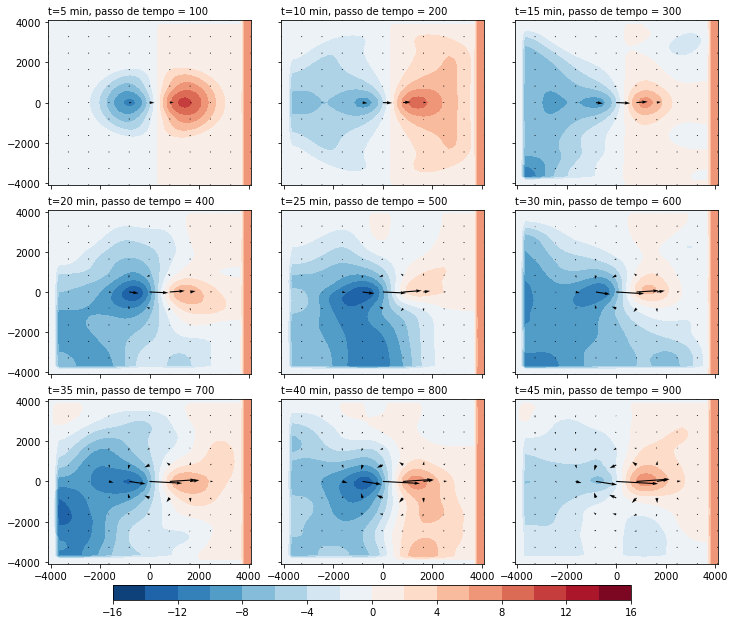

In [233]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
import os

# Parâmetros físicos --------------------------------
g = 9.81            # Aceleração da gravidade [m/s^2]
H = 1               # Altura do fluido [m]
c = np.sqrt(g*H)
q = 7.29*10**(-5)   # velocidade angular     
a = 6371000  

Nx, Ny, dx, dy, Nt, dt  = 40, 40, 100, 100, 1000, 3
x, _ = np.linspace(-(Nx+1)*dx, (Nx+1)*dx, Nx+1, retstep = True)  # Array with x-points
y, _ = np.linspace(-(Ny+1)*dy, (Ny+1)*dy, Ny+1, retstep = True)  # Array with y-points
X, Y = np.meshgrid(x, y)                              # Meshgrid for plotting
X = np.transpose(X)                                   # To get plots right
Y = np.transpose(Y)                                   # To get plots right
f = np.zeros((Ny+1,1))
Nrx = 10                                              # Length wave in x axis
Nry = 4                                               # Length wave in y axis
time_step = 1

# Scenario 1
# ----------
#f[:] = 0                                               # Coriolis [1/s]

# Scenario 2, f = constant with lat = -20 deg
# ----------
#angular = 2*np.pi/86400
#f[:] = 2*angular*np.sin(np.deg2rad(-20))               # Coriolis [1/s]

# Scenario 3
# ----------
beta = np.zeros((Ny+1,1))
lat_deg=np.linspace(-40,40, Ny+1)
for j in range(0,Ny+1):
    beta[j] = 2*q*np.cos(np.deg2rad(lat_deg[j]))/a
    f[j]=beta[j]*Y[0,j]
#dt = 0.1*min(dx, dy)/np.sqrt(g*H)                     # Time step (defined from the CFL condition)
#param_string += "\ndx = {:.2f} km\ndy = {:.2f} km\ndt = {:.2f} s".format(dx, dy, dt)

# Allocating arrays and initial conditions as Arakawa C-grid
# ----------------------------------------------------------
u  = np.zeros((Nt+1, Nx+2, Ny+1))  # zonal wind
v  = np.zeros((Nt+1, Nx+1, Ny+2))  # meridional wind
h  = np.zeros((Nt+1, Nx+1, Ny+1))  # height variation by time
Fu = np.zeros((Nt+1, Nx+1, Ny+1))  # Zonal force like ENSO

# Initial conditions for u, v, & h
# --------------------------------
u[0, :, :] = 0
v[0, :, :] = 0.0 
Fu[:,:,:] = np.exp(-X**2/(Nrx*dx)**2 - Y**2/(Nry*dy)**2) 
h[0, :, :] = 0

t_0 = time.perf_counter()  # For timing the computation loop

# Integration time
# ----------------
for n in range(1, Nt):

    if n == 1: # Euler-forward scheme
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                u[n,i+1,j]= u[n-1,i+1,j] + dt*(-g*(h[n-1,i+2,j  ] - h[n-1,i+1,j])/dx + \
                            f[j]/4*(v[n-1,i,j]+v[n-1,i+1,j]+v[n-1,i+1,j-1]+v[n-1,i,j-1]) + Fu[n,i,j]) 
                v[n,i,j+1]= v[n-1,i,j+1] + dt*(-g*(h[n-1,i  ,j+2] - h[n-1,i,j+1])/dy - \
                            f[j]/4*(u[n-1,i,j]+u[n-1,i,j+1]+u[n-1,i-1,j+1]+u[n-1,i-1,j]))
                h[n,i,j]= h[n-1,i,j] - dt*H*((u[n-1,i,j]-u[n-1,i-1,j])/dx + (v[n-1,i,j]-v[n-1,i,j-1])/dy)
    else: # Leap-frog
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                u[n+1,i+1,j]= u[n-1,i+1,j] + 2*dt*(-g*(h[n,i+2,j] - h[n,i+1,j])/dx + \
                              f[j]/4*(v[n,i,j]+v[n,i+1,j]+v[n,i+1,j-1]+v[n,i,j-1]) + Fu[n,i,j])
                v[n+1,i,j+1]= v[n-1,i,j+1] + 2*dt*(-g*(h[n,i,j+2] - h[n,i,j+1])/dy - \
                              f[j]/4*(u[n,i,j]+u[n,i,j+1]+u[n,i-1,j+1]+u[n,i-1,j]))
                h[n+1,i,j]= h[n-1,i,j] - 2*dt*H*((u[n,i,j]-u[n,i-1,j])/dx + (v[n,i,j]-v[n,i,j-1])/dy)
    
        # Radiational as boundary condition (west, north, south)
        # ------------------------------------------------------
        # west
        u[n+1,0,:]= u[n,0,:] + dt*(c*(u[n,1,:]-u[n,0,:])/dx)
        # north
        v[n+1,:,-1]= v[n,:,-1] - dt*(c*(v[n,:,-2]-v[n,:,-1]/dy))
        # south
        v[n+1,:,0]= v[n,:,0] - dt*(c*(v[n,:,1]-v[n,:,0]/dy))
    
    # Fixed boundary condition at east
    h[n,-2::,:] =  8
    u[n,-2::,:] =  0
                
# Plot -------------------------------------------------
fig, axes = plt.subplots(3,3, figsize=(12,10), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, n in zip(axes.flatten(), list(range(100,901,100))):
    im = ax.contourf(X, Y, h[n,:,:], cmap=plt.cm.RdBu_r, levels=list(range(-16,18,2)))
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], u[n,::4, ::4], v[n,::4, ::4],
        units = "xy", scale = 1)
    qk = ax.quiverkey(Q, 0.9, 0.0, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title("t={:.0f} min, passo de tempo = {:.0f}".format(dt*n/60, n), fontsize=10, loc='left')
cax = fig.add_axes([.2,.075,.6,.02]) # left, bottom, width, height
fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
fig.savefig("fig/leapfrog_1m_beta.png", dpi = 300, bbox_inches='tight', facecolor='w')
# ------------------------------------------------------
print("Main computation loop done!\nExecution time: {:.2f} s".format(time.perf_counter() - t_0))

In [234]:
filenames = []
# plot the line chart
    
for n in range(1,Nt,2):
    fig, ax = plt.subplots()
    im = ax.contourf(X, Y, h[n,:,:], cmap=plt.cm.RdBu_r, levels=list(range(-16,18,2)))
    fig.colorbar(im, ax=ax, orientation="vertical")
    ax.set_title("t={:.0f} min, passo de tempo = {:.0f}".format(dt*n/60, n), fontsize=10, loc='left')
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], u[n,::4, ::4], v[n,::4, ::4], units = "xy", scale = 1)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=200)
    plt.close() # build gif

with imageio.get_writer('gifs/leap_1m_beta.gif', mode='I', duration = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  